# Non-Linearity

Am văzut în lecția precedentă că pentru un set de date liniare, modelul pe care l-am creat învață din datele de antrenare și se comportă perfect pe datele de testare (după ce am antreant pe aprozimativ 10-15.000 de epoci). Pentru a face ca modelul să poată să învețe și din aceste date trebuie să utilizăm și anumite layere de tipul non-linear. O rețea neuronală practic este o combinație de layere atât liniare cât și non-liniare. Deoarece la modelul anterior am folosit doar layere liniare, acesta nu avea cum să învețe pentru un set de date care este non-liniar. În continuare o să ne creem din nou acel set de date circular cu care am lucrat

In [1]:
# importing the libraries
import torch
from torch import nn

import pandas as pd
import seaborn as sns

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

In [2]:
# create the dataset
X, y = make_circles(n_samples=1000, noise=0.03, random_state=42)

In [3]:
# create a pandas DataFrame with the data
df = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "labels": y
})

df.head()

,X1,X2,labels
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


<Axes: xlabel='X1', ylabel='X2'>

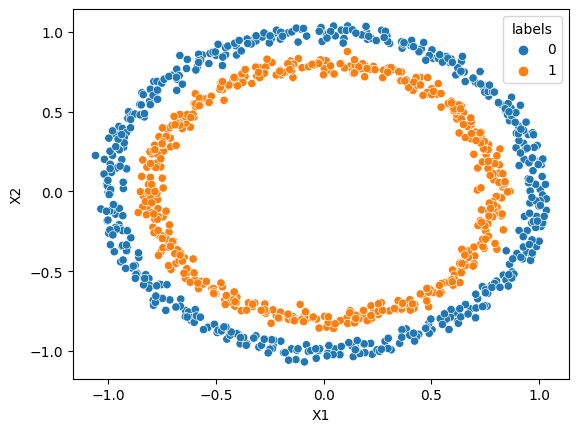

In [4]:
# visualize the data
sns.scatterplot(data=df, x="X1", y="X2", hue="labels")

In [5]:
# transform the data into tensors
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [6]:
X.dtype

torch.float32

In [7]:
# split the data into train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Acum că ne-am creat setul de date putem să trecem la partea în care ne creem modelul. După cum specificam, un model este o combinație de layere atât liniare cât și non-liniare. Ca și layere liniare am folosit până în acest moment `nn.Linear()` care este printre cele mai utilizate layere liniare din PyTorch. În ceea ce privește partea de layere non-liniare, PyTorch are la dispoziți eo mulțime de astfel de layere, dar printre cel mai folosit este `nn.ReLU()`. În continuare o să ne creem o clasă în care o să ne creem iniția un model cu 4 layere liniare (precum modelul anterior)

In [8]:
class CircleModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.layer1 = nn.Linear(in_features=2, out_features=8)
        self.layer2 = nn.Linear(in_features=8, out_features=16)
        self.layer3 = nn.Linear(in_features=16, out_features=8)
        self.layer4 = nn.Linear(in_features=8, out_features=1)

    def forward(self, x):
        return self.layer4(self.layer3(self.layer2(self.layer1(x))))

Modelul de mai sus este un model care are 4 layere liniare. Ca să îmbunătățim acest layer pentru cazul la care lucrăm o să avem nevoie și de layere non-liniare. În continuare o să ne creem un layer non-liniar în cadrul acestui model. Un astfel de layer non-liniar (`nn.ReLU()`) nu are nevoie de niciun parametru. Acest layer nu o să ne genereze anumiți parametrii ai modelului precum face layer-ul **nn.Linear()** care ne creează pentru fiecare layer câte un parametru de *weight* și unul de *bias*. Acuma o să modificăm modelul prin adăugarea unui layer non-liniar

In [10]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Linear(in_features=2, out_features=8)
        self.layer2 = nn.Linear(in_features=8, out_features=16)
        self.layer3 = nn.Linear(in_features=16, out_features=8)
        self.layer4 = nn.Linear(in_features=8, out_features=1)
        self.relu = nn.ReLU()


Acesta este modelul îmbunătățit care conține și layere non-liniare. Pentru ca modelul respectiv să funcționeze în cel mai  bun mod, aceste layere trebuie combinate. Cum anume se combină acestea? Între fiecare layer liniar trebuie să adăugăm acel layer non-liniare. Asta putem să facem în cadrul funcție **forward()** unde se realizează computația în cadrul modelului.

In [11]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Linear(in_features=2, out_features=8)
        self.layer2 = nn.Linear(in_features=8, out_features=16)
        self.layer3 = nn.Linear(in_features=16, out_features=8)
        self.layer4 = nn.Linear(in_features=8, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer4(self.relu(self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))))

După cum am spus, între fiecare layere liniare trebuie să aplicăm acel layer non-liniar pentru ca modelul să fie corect și să se comporte bine. Ceea ce este returnat în cadrul acelei metode *forward()*  este destul de complicat de urmărit și de înțeles. Din moment ce acele layere se rulează secvențial, putem să ne construim un astfel de model de unde o să se înțeleagă mai bine cum anume funcționează aceste layere unul după altul

In [13]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.ReLU(),
    nn.Linear(in_features=8, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=8),
    nn.ReLU(),
    nn.Linear(in_features=8, out_features=1)
)

Acum că avem modelul respectiv putem să creem primele predicții cu acest model, după care să îl antrenăm și să verificăm dacă acum acest model învață ceva din datele respective. O să creem predicțiile cu modelul neantrenat.

In [14]:
with torch.inference_mode():
    untrained_preds = model_0(X_test)

Acum după ce am creat modelul respectiv putem să trecem la parte în care antrenăm acest model și verificăm perfomața acestuia utilizând partea de loss și de accuracy

In [44]:
# select a loss function and a optimizer
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.05)

In [28]:
# calculate accuracu
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [51]:
# train and test loop
epochs = 1000
for epoch in range(epochs):
    model_0.train()
    train_logits = model_0(X_train).squeeze()
    train_preds = torch.round(torch.sigmoid(train_logits))

    train_loss = loss_fn(train_logits, y_train)
    train_acc = accuracy_fn(y_train, train_preds)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    # model evaluation
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_preds)

    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f} | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}')

Epoch: 0 | Train loss: 0.00158 | Train accuracy: 100.00 | Test loss: 0.01051 | Test accuracy: 99.50
Epoch: 100 | Train loss: 0.00157 | Train accuracy: 100.00 | Test loss: 0.01049 | Test accuracy: 99.50
Epoch: 200 | Train loss: 0.00155 | Train accuracy: 100.00 | Test loss: 0.01048 | Test accuracy: 99.50
Epoch: 300 | Train loss: 0.00153 | Train accuracy: 100.00 | Test loss: 0.01046 | Test accuracy: 99.50
Epoch: 400 | Train loss: 0.00151 | Train accuracy: 100.00 | Test loss: 0.01045 | Test accuracy: 99.50
Epoch: 500 | Train loss: 0.00150 | Train accuracy: 100.00 | Test loss: 0.01043 | Test accuracy: 99.50
Epoch: 600 | Train loss: 0.00148 | Train accuracy: 100.00 | Test loss: 0.01041 | Test accuracy: 99.50
Epoch: 700 | Train loss: 0.00146 | Train accuracy: 100.00 | Test loss: 0.01040 | Test accuracy: 99.50
Epoch: 800 | Train loss: 0.00145 | Train accuracy: 100.00 | Test loss: 0.01038 | Test accuracy: 99.50
Epoch: 900 | Train loss: 0.00143 | Train accuracy: 100.00 | Test loss: 0.01037 | Tes

După ce am adus acele modificări asupra modelului prin care am introdus și acelel layere non-liniare și am antreanat modelul respectiv pentru un număr relativ mare de epoci (undeva la 10.000),  se poate obsera acuma că modelul respectiv are o acuratețe de 99%, adică aproape perfect este acest model acuma. Problema inițială (la începutul acestei secțiuni) cu modelul anterior a fost aceea cum că modelul respectiv a fost alcătuit doar din layere liniare, iar pentru datele cu care s-a lucrat a fost nevoie de combinarea dintre layere atât liniare cât și non-liniare. Oricum de cele mai multe ori în cadrul unui model de Deep Learning o să avem mai multe combinații de layere prin care se poate crea un anumit model. Scopul unui Data Scientis este să înțeleagă problema care trebuie rezolvată și să găsesască combinația perfectă între layere pentru a ajunge la un model cu o acuratețe și precizie cât mai mare.

In [52]:
with torch.inference_mode():
    y_preds = model_0(X_test)

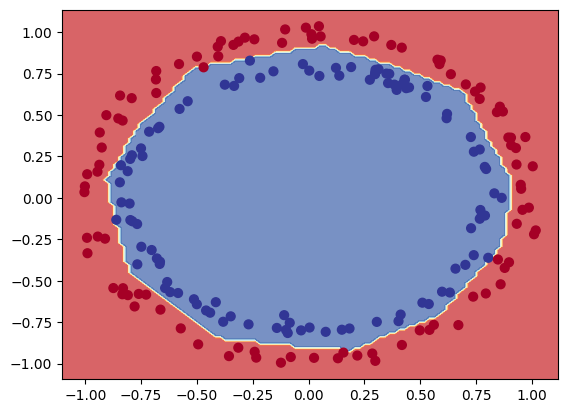

In [53]:
from helper_functions import plot_decision_boundary
plot_decision_boundary(model_0, X_test, y_test)

Acum după ce am creat noul model, l-am antreant și am făcut predicții, în momentul în care vizualizăm datele resepctive și cum sunt acuma împărțite, se poate observa faptul că nu mai avem o linie dreaptă care încearcă să separe datele, ci acuma avem o combinație de linii atât drepte cât și curbe care creează această separare între datele respective. Aceste linii drepte și curbe provin din utilizarea atât a unor layere de tip liniare (**nn.Linear()**) cât și a unor layere de tip non-liniare (**nn.ReLU()**) Împărțirea datelor nu este perfectă, dar cu mai multă antrenare sau prin modificarea acelui learning rate s-ar putea ajunge la un model perfect în acest caz.

## Recapitulare

În cadrul acestei lecții am învățat următoarele lucruri:

1. Un model de Deep Learning este creat de cele mai multe ori printr-o combinație de layere (liniare, non-liniare sau alte layere)

2. Care este layer-ul non-liniar ce este cel mai des folosit
```python
import torch
non_linear_layer = torch.nn.ReLU()
```
3. Cum să creem un model care conține atât layere liniare cât și layere non-liniare
```python
import torch
from torch import nn

class TestModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear_layer1 = nn.Linear(in_features=2, out_features=10)
        self.linear_layer2 = nn.Linear(in_features=10, out_features=10)
        self.linear_layer3 = nn.Linear(in_features=10, out_features=1)
        self.non_linear_layer = nn.ReLU()
```

4. Cum trebuie combinate cele două layere pentru a realiza un model cât mai potrivit. Un layer non-liniar trebuie să fie prezent între două layere liniare pentru a funcționa corect
```python
import torch
from torch import nn

class TestModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear_layer1 = nn.Linear(in_features=2, out_features=10)
        self.linear_layer2 = nn.Linear(in_features=10, out_features=10)
        self.linear_layer3 = nn.Linear(in_features=10, out_features=1)
        self.non_linear_layer = nn.ReLU()

    def forward(self, x):
        return self.linear_layer3(self.non_linear_layer(self.linear_layer2(self.non_linear_layer(self.linear_layer1(x)))))
```

5. Un astfel de model este mai bine creat utilizând un model secvențial
```python
import torch
from torch import nn

model = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=1)
)

```